In [ ]:
# inspired by https://arxiv.org/pdf/1907.02704.pdf and thu vu data analysis
# TODO: 
# IMPORTANT: change df structure to name (with multiplical names) and "all names"
# geneaological

In [40]:
import pandas as pd
import time
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import unidecode
import networkx as nx

print('package loaded')

website_choices = [{"name": "https://lotr.fandom.com/wiki/Category:", 
                   "url" : ["The_Hobbit_Characters", "The_Silmarillion_characters", "Characters_in_The_Children_of_H%C3%BArin"]},
                   {"name": "https://tolkiengateway.net/wiki/Category:", 
                    "url" : ["Characters_in_The_Hobbit", "Characters_in_The_Lord_of_the_Rings"]}
                  ]
choice = website_choices[1]
path = choice["url"][1]

print(choice['name'], 'website', path, 'book')

package loaded
https://tolkiengateway.net/wiki/Category: website Characters_in_The_Lord_of_the_Rings book


## Book analysis

### Setup

In [44]:
characters_df = pd.read_json("data/mining/" + path +".json")
# TODO put unicode in column names in data scrapping 
characters_df = characters_df.rename(columns = {"other names": "other names"})
characters_df.head(3)

,names,link,race,other names,gender,birth,death,affiliation,rule
0,Anborn,https://tolkiengateway.net/wiki/Anborn,Gondorian,None,Male,Late Third Age,None,None,None
1,Angbor,https://tolkiengateway.net/wiki/Angbor,Gondorian,"""the Fearless""",Male,Late Third Age,None,None,None
2,Aragorn,https://tolkiengateway.net/wiki/Aragorn,Arnorian,"Aragorn II, Elessar, Strider, Thorongil, The D...",Male,1 March T.A. 2931\nEriador,1 March Fo.A. 120[3] (aged 210)\nGondor,Fellowship of the Ring,T.A. 2933 - 3019 (Chieftain)\nT.A. 3019 - Fo.A...


#### Filters the characters_df to get only certain affiliation (like Fellowship of the Ring) (FACULTATIVE)

In [42]:
characters_df["affiliation"].value_counts()

# Replace NaN values with a placeholder string
characters_df["affiliation"] = characters_df["affiliation"].fillna("N/A")

# Select rows where the "affiliation" column contains "Fellowship"
filtered_df = characters_df[characters_df["affiliation"].str.contains("Fellowship|Sauron|Gondor|Morgoth|Aulë", regex = True)]

# Filter out rows where "affiliation" is NaN
filtered_df = filtered_df[pd.notnull(filtered_df["affiliation"])]

# Assign the filtered_df to the used df
characters_df = filtered_df

In [43]:
characters_df["race"].value_counts()

# Replace NaN values with a placeholder string
characters_df["race"] = characters_df["race"].fillna("N/A")

# Select rows where the "affiliation" column contains "Fellowship"
filtered_df = characters_df[characters_df["race"].str.contains("Hobbit", regex = True)]

# Filter out rows where "affiliation" is NaN
filtered_df = filtered_df[pd.notnull(filtered_df["race"])]

# Assign the filtered_df to the used df
characters_df = filtered_df

In [3]:
display(characters_df.loc[characters_df["names"].str.contains("Sam")])

,names,link,race,other names,gender,birth,death,affiliation,rule
121,Samwise Gamgee,https://tolkiengateway.net/wiki/Samwise_Gamgee,Hobbit,Banazîr (H)\nPerhael (S),Male,6 April T.A. 2980[note 1]\nThe Shire,None,Fellowship of the Ring,Fo.A. 6 - 55


#### Modify the characters_df to fit the text analysis

In [45]:
# MAYBE have to be refactored, cause was used when there were no 'all names' column

def surname_modification(x, to_change = {}, exception = [], contain = []):
    # to_change, change_into is to set names that are to be replaced
    # exception is names that DO NOT have to be changed
    # contain is First part of a word that has to be replaced
    if contain == []:
        contain.append([""]) # trick to make following lines relevant if contain is empty
    if x in exception:
        return x
    word_split = x.split(" ", 1)
    if len(word_split)>1:
        for word in word_split:
            if word in to_change:
                x = to_change[word]
                break
        else:
            x = word_split[0]
    return unidecode.unidecode(x)

to_change = {"Eagle": "Eagles", "Meriadoc": "Merry", "Peregrin": "Pippin",
             "Bombadil": "Bombadil", "Ferny": "Ferny", "Pickthorn" : "Pickthorn"}

contain = ["Great", "Mr.",  "Mr", "Mrs"]

exception = ["King of the Dead", "Durin's Bane", "Daddy Twofoot", "Mouth of Sauron", 
             "Captains of the West", "Harry Goatleaf", "Hob Hayward",
            "Hound of Sauron", "Old Man Willow", "Old Noakes", "Warden of the Houses of Healing", 
            
            "Great Goblin",]

to_keep = ["Cotton", "Shelob", "Horn"]

to_add = {'Bilbo Baggins' : ['Barrel-rider', 'Bilba Labingi', 'Burglar', 'Child of the Kindly West',
                             'Clue-finder', 'Luckwearer', 'Mad Baggins', 'Mr. Lucky Number', 'the Magnificent', 'Ringwinner',
                             'Stinging Fly', 'Thief', 'Web-cutter'], 
         "Durin's Bane" : ['Balrog'], 'Samwise': ['Sam', 'Gamgee']} 
#gandalf might speak of Balrog eventhough it does not refere to Durin's bane, but help to discriminate communites later

Simplification: certains personnages ont le même prénom (Tom bombadil) donc on garde le nom pour différencier. Sur une séquence, si un personnage est évoqué, son nom l'est en général.
Il faudrait ajouter une fonctionnalité pour ajouter des noms dans la function merge_names (comme ajouter Sam à Samwise, plutot que de le remplacer !) ou alors dans la fonction ci-dessus mais ça la rendrait moins réutilisable dans un contexte où on utilise que les "names" pour l'analyse du livre

Egalement, penser à supprimer "Captains of the West" entre autres

In [46]:
import re

# Version with re library

def merge_names(row):
    # Combine the two columns into a single string
    names_str = row['names']
    if row['other names']: # necessary because 'other names' is sometimes None value
        names_str += ',' + row['other names']
    names_str = unidecode.unidecode(names_str) 
    
    # Replace newlines with spaces
    names_str = names_str.replace('\n', ',')

    # Remove parentheses () and brackets [] and everything inside them
    names_str = re.sub(r'\[[^\]]*\]|\([^)]*\)', '', names_str)

    # Remove double quotes
    names_str = names_str.replace('"', '')
    
    # Split the string on commas, and strip leading/trailing whitespace
    names = [name.strip() for name in names_str.split(',') if name.strip()]
    
    # Add names that were not found in the data
    for name in to_add.keys():
        if name in names[0]:
            names += to_add[name]
    
    # Modify the surname of the characters  
    if any(keep in names[0] for keep in to_keep):
        names = [row['names']]
    else:
        names[0] = surname_modification(names[0], to_change, exception, contain)
    return names

# Apply the function to each row of the DataFrame
characters_df['all names'] = characters_df.apply(merge_names, axis=1)
characters_df.to_json('data/mined_modified/'+ path + '.json', orient='records')

In [8]:
characters_df.loc[characters_df['names'].str.contains("Bert")]


,names,link,race,other names,gender,birth,death,affiliation,rule,all names
6,Bert,https://tolkiengateway.net/wiki/Bert,Troll,None,Male,None,T.A. 2941\nTrollshaws,None,None,[Bert]


#### Set the relationships to default

In [47]:
relationships = []
relationship_dict = {}

for source in characters_df['names']:
    for target in characters_df['names']:
        if source == target:
            continue
        relationship_dict = {}
        relationship_dict['source'] = source
        relationship_dict['target'] = target
        relationship_dict['weight'] = 0
        relationships.append(relationship_dict)
relationships_df = pd.DataFrame(relationships)
relationships_df.to_json("data/relations/relationships_"+ path + "_zero.json")
relationships_df.head(5)

,source,target,weight
0,Anborn,Angbor,0
1,Anborn,Aragorn,0
2,Anborn,Arwen,0
3,Anborn,Barliman Butterbur,0
4,Anborn,Barrow-wights,0


#### Get book's content and seperate it in chapters

In [60]:
book = []
new_chapter = ""
books = {"Hobbit" : "hobbit.txt", 
         "LOTR 1" : "lotr_1.txt", "LOTR 2" : "lotr_2.txt", "LOTR 3" : "lotr_3.txt"}

with open("data/books/" + books["LOTR 3"]) as file:
    for line in file:
        line_corrected = line.rstrip()
        if "Chapter" in line_corrected and len(line_corrected) < 50:
            # seperates book in chapters, and removes the line "Chapter XX"
            if new_chapter != "":
                book.append(new_chapter)
            new_chapter = ""
            continue
        if len(line_corrected)>1:
            new_chapter += line_corrected + "\n"

### Analysis

#### Compute the interactions between characters

In [56]:
relationships_df = pd.read_json("data/relations/relationships_"+ path + "_zero.json")

In [61]:
def co_occurence_scene_all_names(characters_in_scene, character, scene, characters_df):
    # Get the list of names for the character
    names = characters_df.loc[characters_df['names'] == character, 'all names'].iloc[0]
    # Check if any of the names are present in the scene
    if any(name in scene for name in names) and character not in characters_in_scene:
        characters_in_scene.append(character)

iterator = 0
for chapter in book:
    scene_length = 2500
    prev_iteration = 0
    chapter_length = len(chapter)

    for iteration in range(scene_length, chapter_length, scene_length):
        scene = chapter[prev_iteration:iteration]
        # if the next text interval is not long enough to be superior to scene_length, expand it 
        if chapter_length < iteration + scene_length:
            scene += chapter[iteration:]
        
        # will check if there were co occurrences in the scene
        characters_in_scene = []
        for character in characters_df["names"]:
            co_occurence_scene_all_names(characters_in_scene, character, scene, characters_df)
        
        # will set up the relationship df according to if there we co occurrences in the scene
        for source in characters_in_scene:
            for target in characters_in_scene:
                relationships_df.loc[(relationships_df['source'] == source) & (relationships_df['target'] == target), "weight"] += 1

        prev_iteration = iteration
    iterator += 1
    progress = int(iterator/len(book) * 100)
    print(progress, " % progress")
    
relationships_df = relationships_df.loc[(relationships_df['weight'] > 0)]
relationships_df.to_json("data/relations/relationships_" + path + ".json")
print("relations attributed")

5  % progress
11  % progress
16  % progress
22  % progress
27  % progress
33  % progress
38  % progress
44  % progress
50  % progress
55  % progress
61  % progress
66  % progress
72  % progress
77  % progress
83  % progress
88  % progress
94  % progress
100  % progress
relations attributed


#### Setup of the network graph

In [27]:
#### Parameters
louvain_resolution = 1.15 # Sets the resolution of the Louvain Algorithm
louvain_seed = 1
spring_seed = 1

dict_values([44, 18, 16, 53, 15, 11, 36, 21, 9, 14, 10, 13, 46, 8, 23, 21, 61, 25, 17, 51, 14, 29, 21, 24, 16, 19, 9, 28, 4, 14, 47, 42, 30, 13, 15, 43, 13, 54, 34, 36, 16, 20, 30, 11, 5, 11, 13, 15, 7, 13, 12, 13, 14, 14, 17, 10, 8, 6, 7, 13, 6, 4, 3, 7, 5, 7])


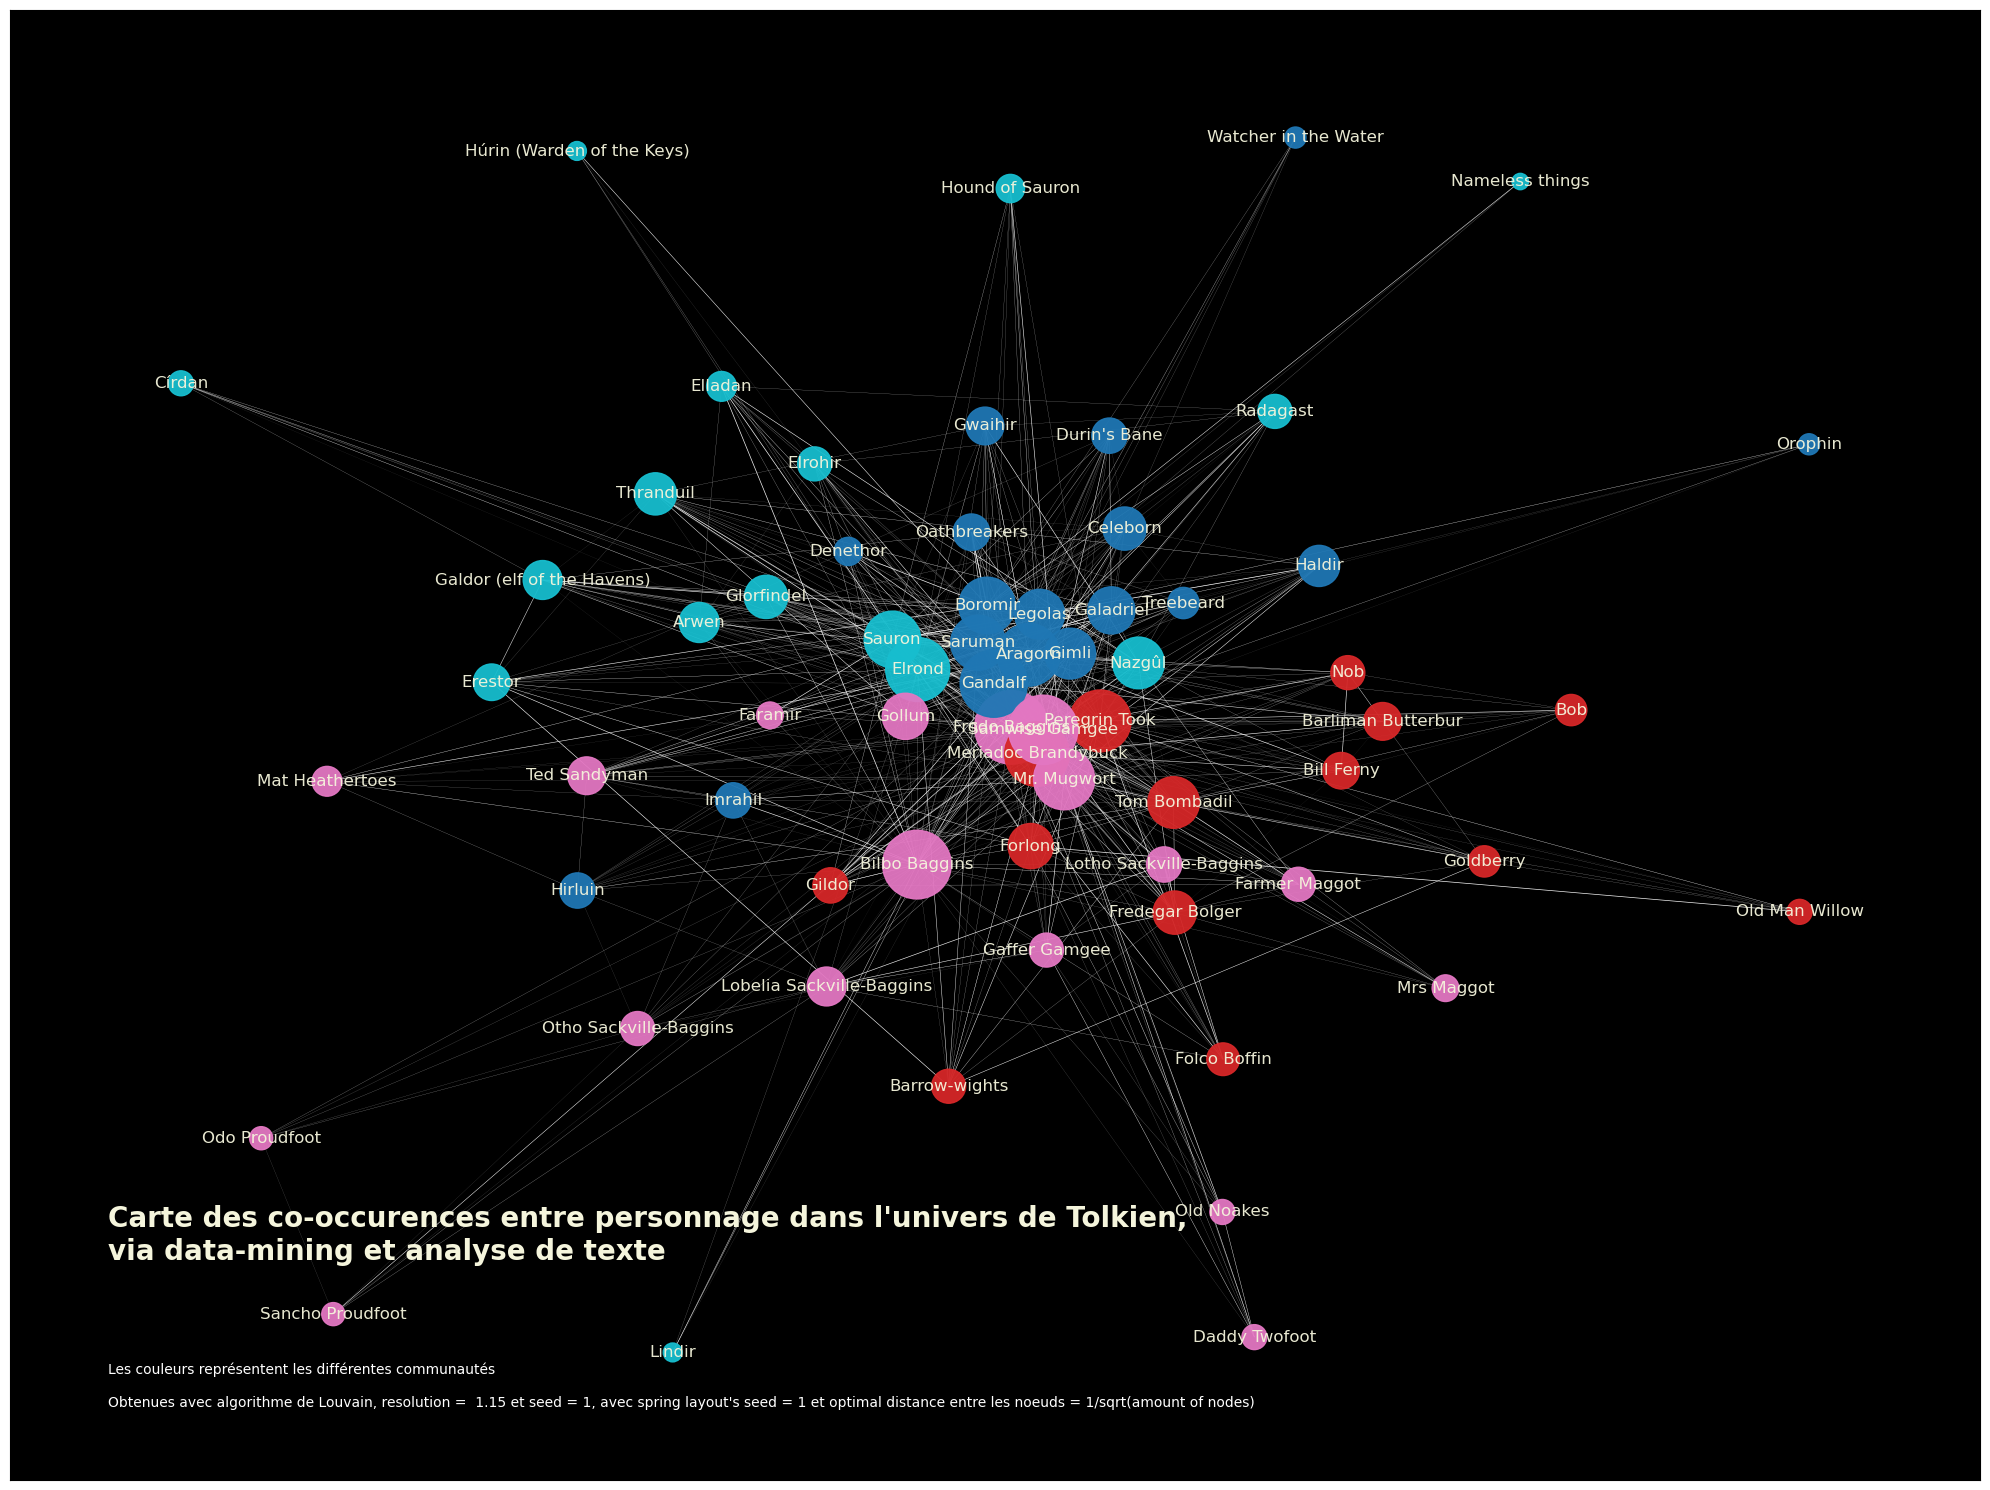

In [62]:
##### Create a graph from a pandas dataframe

relationships_df = pd.read_json("data/relations/relationships_" + path + ".json")
relationships_df = relationships_df.loc[(relationships_df['weight'] > 0)]

G = nx.from_pandas_edgelist(relationships_df, 
                            source = "source", 
                            target = "target", 
                            edge_attr = "weight",
                            create_using = nx.Graph())

# largest connected component
components = nx.connected_components(G)
largest_component = max(components, key=len)
H = G.subgraph(largest_component)

# compute centrality
#centrality = nx.betweenness_centrality(G, k=10, endpoints=True)
centrality = nx.degree_centrality(G)
#centrality = nx.closeness_centrality(G)

# compute community structure
lpc = nx.algorithms.community.louvain_communities(G, weight='weight', resolution=louvain_resolution, threshold=1e-07, seed=1)
community_index = {n: i for i, com in enumerate(lpc) for n in com}
nx.set_node_attributes(G, community_index, 'community')

#### draw graph ####
degree_dict = dict(G.degree)
fig, ax = plt.subplots(figsize=(20, 15))
ax.set_facecolor("black")
pos = nx.spring_layout(G, seed=spring_seed, fixed = ['Bilbo Baggins'], pos = {'Bilbo Baggins': (0,0)})
# first seed = 4572321
node_color = [community_index[n] for n in G]
node_size = [v * 3000 for v in centrality.values()]
# node_size = [v * 3000 /max(degree_dict.values()) for v in degree_dict.values()]
linewidths = [v/(max(degree_dict.values()) * 2) for v in degree_dict.values()]
linecolor = [community_index[n] for n in G]

nx.draw_networkx(
    G,
    pos=pos,
    with_labels=True,
    node_color=node_color,
    node_size=node_size,
    width = linewidths,
    alpha = 0.95,
    cmap = "tab10",
    font_color = "beige",
    edge_color= "white",
    edge_cmap = "tab10"
)
# Title/legend

# Change font color for legend

ax.text(
    0.05,
    0.05,
    "Les couleurs représentent les différentes communautés\n\nObtenues avec algorithme de Louvain, resolution =  " + str(louvain_resolution) +  " et seed = " + str(louvain_seed) + ", avec spring layout's seed = " + str(spring_seed) + " et optimal distance entre les noeuds = 1/sqrt(amount of nodes)",
    horizontalalignment="left",
    transform=ax.transAxes,
    color = "white",
    fontweight = "light", 
    fontsize = 10,
)

ax.text(
    0.05,
    0.15,
    "Carte des co-occurences entre personnage dans l'univers de Tolkien,\nvia data-mining et analyse de texte",
    horizontalalignment="left",
    transform=ax.transAxes,
    color = "beige",
    fontweight = "bold", 
    fontsize = 20,
)
plt.plot()
fig.tight_layout()
plt.savefig("img/network2.png")
print(degree_dict.values())

In [63]:
nx.write_gexf(G , path + ".gexf" )

In [37]:
display(relationships_df.loc[relationships_df["source"].str.contains("Bert")])

,source,target,value
240,Bert,Azog,0
241,Bert,Balin,0
242,Bert,Bandobras Took,0
243,Bert,Bard,0
244,Bert,Belladonna Took,0
245,Bert,Beorn,0
246,Bert,Bifur,0
247,Bert,Bilbo Baggins,0
248,Bert,Bodyguard of Bolg,0
249,Bert,Bofur,0


In [ ]:
list(nx.bridges(G))

[]

## Others

In [ ]:
relationships_df.values

array([['Balin', 'Bard', 1],
       ['Balin', 'Beorn', 1],
       ['Balin', 'Bifur', 1],
       ['Balin', 'Bilbo Baggins', 6],
       ['Balin', 'Bofur', 1],
       ['Balin', 'Bombur', 1],
       ['Balin', 'Dori', 1],
       ['Balin', 'Dwalin', 1],
       ['Balin', 'Elrond', 7],
       ['Balin', 'Gandalf', 12],
       ['Balin', 'Great Eagle', 1],
       ['Balin', 'Master of Lake-town', 1],
       ['Balin', 'Nori', 1],
       ['Balin', 'Ori', 3],
       ['Balin', 'Thorin', 3],
       ['Balin', 'Thranduil', 1],
       ['Bandobras Took', 'Bilbo Baggins', 2],
       ['Bandobras Took', 'Gandalf', 1],
       ['Bandobras Took', 'William', 1],
       ['Bard', 'Balin', 1],
       ['Bard', 'Beorn', 1],
       ['Bard', 'Bifur', 1],
       ['Bard', 'Bilbo Baggins', 1],
       ['Bard', 'Bofur', 1],
       ['Bard', 'Bombur', 1],
       ['Bard', 'Dori', 1],
       ['Bard', 'Dwalin', 1],
       ['Bard', 'Elrond', 1],
       ['Bard', 'Gandalf', 1],
       ['Bard', 'Master of Lake-town', 1],
       ['Bar